## 4) 多类别分类

本例采用方法的核心就是：将**分类标签映射到10向量**（一个1多个0，1的位置就是标签集索引），然后每个标签构建一个模型。 采用**10折交叉验证**的方法，计算惩罚步数所对应的**误分率**，并绘制成图。 

在手工10折交叉验证循环中用算法sklearn.linear_model.enet_path进行elasticNet线性回归路径分析。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import enet_path
from sklearn.metrics import roc_auc_score, roc_curve

target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
df = pd.read_csv(target_url, header=None, prefix="V")
df.columns = ['Id','RI','Na', 'Mg', 'Al', 'Si','K', 'Ca', 'Ba', 'Fe', 'Type']
df = df.set_index("Id")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
Id,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [5]:
# 切分属性和标签
xData = df.values[:,:-1]; yLabel = df.values[:,-1] 

# 标签值向量化(一对所有)
labelList = list(set(yLabel))
labelList.sort()
nlabels = len(labelList)
def mapfunc(label):
    idx = labelList.index(label)
    row = [0]*nlabels
    row[idx] = 1
    return row
yData = np.array([mapfunc(label) for label in yLabel])
yData

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

/home/x/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


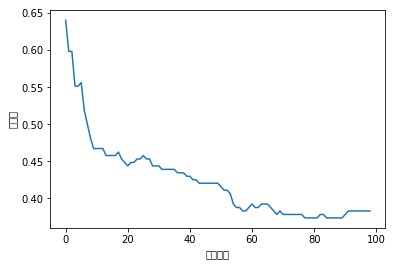

In [6]:
# 标准化
xData = (xData - xData.mean(axis=0))/xData.std(axis=0)
yMean = yData.mean(axis=0); yStd = yData.std(axis=0)
yData = (yData - yMean)/yStd

# 数据规模
m, n = xData.shape

# 手工构建n折交叉验证循环
nxval = 10
nAlphas= 100
misClass = [0.0] * nAlphas
for ixval in range(nxval):   
    # 第ixval折验证的训练集和测试集的切分
    idxTest = [i for i in range(m) if i%nxval == ixval%nxval]
    idxTrain = [i for i in range(m) if i%nxval != ixval%nxval]    
    xTest = xData[idxTest,:]; yTest = yData[idxTest,:]
    xTrain = xData[idxTrain,:]; yTrain = yData[idxTrain,:]
    labelTest = yLabel[idxTest]    

    # 为yTrain的每列建立模型
    # enet_path 就是 ElasticNet正规化路径
    # 参数：l1_ratio就是套索惩罚项的占比
    models = [enet_path(xTrain, yTrain[:,k] ,l1_ratio=1.0, fit_intercept=False, 
                        eps=0.5e-3, n_alphas=nAlphas , return_models=False) 
              for k in range(nlabels)]
    
    lenTest = m - len(yTrain)
    for iStep in range(1,nAlphas):
        # 组合所有模型的预测
        allPredictions = []
        for iModel in range(nlabels):
            # 模型预测
            _, coefs, _ = models[iModel]
            predTemp = np.dot(xTest, coefs[:,iStep])
            
            # 去标准化后比较
            predUnNorm = predTemp*yStd[iModel]+yMean[iModel]
            allPredictions.append(list(predUnNorm))
        allPredictions = np.array(allPredictions)

        # 找出最大的预测和误差        
        predictions = []
        for i in range(lenTest):
            listOfPredictions = allPredictions[:,i]
            idxMax = listOfPredictions.argmax()
            if labelList[idxMax] != labelTest[i]:
                misClass[iStep] += 1.0

misClassPlot = [misClass[i]/m for i in range(1, nAlphas)]

plt.plot(misClassPlot)

plt.xlabel(u"惩罚步数")
plt.ylabel((u"误分率"))
plt.show()